# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(y_train)

# Number of validation examples
n_validation = len(y_valid)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
N_CLASSES = np.max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", N_CLASSES)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

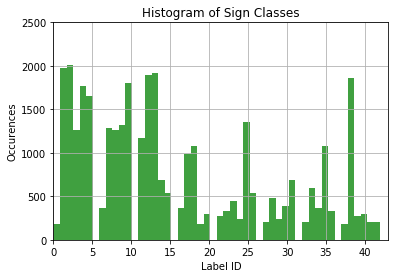

In [4]:
n, bins, patches = plt.hist(y_train, 50, density=0, facecolor='g', alpha=0.75)

plt.xlabel('Label ID')
plt.ylabel('Occurences')
plt.title('Histogram of Sign Classes')
plt.axis([0, 43, 0, 2500])
plt.grid(True)
plt.show()


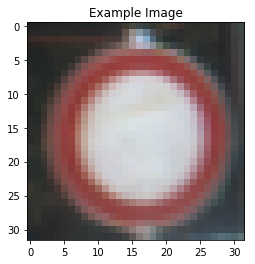

In [5]:
rand_ind = np.random.randint(0, n_train)
rand_img = X_train[rand_ind]
plt.title('Example Image')
plt.imshow(rand_img)

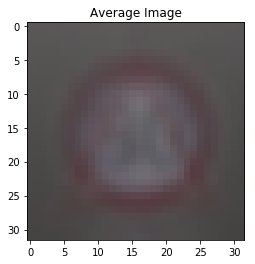

In [6]:
avg_img = np.average(X_train, 0) / 255
plt.title('Average Image')
plt.imshow(avg_img)

### Pre-process the Data Set (normalization, grayscale, etc.)

In [7]:
IMAGE_SIZE=24

def get_train_batch(images=X_train, labels=y_train, batch_size=32):
    """Get a batch of training input to model
    
    Args:
        images: numpy.ndarray of images
        labels: numpy.ndarray of labels
        batch_size: number of examples to batch in model
        
    Returns: batch of transformed training data
        """
    assert images.shape[0] == labels.shape[0]
    with tf.name_scope('image_preprocessing'):
        dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(n_train)
        def _preprocess_image(image):
            image = tf.cast(image, tf.float32)
            image = tf.random_crop(image, [IMAGE_SIZE, IMAGE_SIZE, 3])
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
            image = tf.image.per_image_standardization(image)
            return image
        dataset = dataset.map(lambda image,label: (_preprocess_image(image), tf.cast(label, tf.int32)))
        dataset = dataset.batch(batch_size).repeat()
        return dataset.make_one_shot_iterator().get_next()

def get_validation_batch(images=X_valid, labels=y_valid, batch_size=32):
    """Get a batch from the validation dataset.  Function will repeat dataset when end is reached.
    Args:
        images: numpy array of feature images
        labels: numpy array of labels
        batch_size: size of batch
    """
    return _get_evaluation_data(images, labels, batch_size)

def get_test_batch(images=X_test, labels=y_test, batch_size=32):
    """Get a batch from the test dataset.  Function will repeat dataset when end is reached.
    Args:
        images: numpy array of feature images
        labels: numpy array of labels
        batch_size: size of batch
    """
    return _get_evaluation_data(images, labels, batch_size)

def _get_evaluation_data(images, labels, batch_size):
    assert images.shape[0] == labels.shape[0]
    with tf.name_scope('validation_preprocessing'):
        dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(len(labels)).repeat()
        def _preprocess_image(image):
            image = tf.cast(image, tf.float32)
            image = tf.image.resize_image_with_crop_or_pad(
                    image,
                    IMAGE_SIZE,
                    IMAGE_SIZE)
            image = tf.image.per_image_standardization(image)
            return image
        dataset = dataset.map(lambda image,label: (_preprocess_image(image), tf.cast(label, tf.int32)))
        dataset = dataset.batch(batch_size)
        return dataset.make_one_shot_iterator().get_next()


### Model Architecture

In [8]:
import tensorflow as tf
import numpy as np
from signs_input import get_train_batch, get_validation_batch

def get_network(n_classes, l2_scale, hidden_units):
    """Create an inference function based on VGGNet
        Args:
            n_classes: number of unnormalized logits to output
            l2_scale: regularization constant
            hidden_units: list of integers defining the width of fully-connected layers
    """
    def inference(images):

        regularizer = tf.contrib.layers.l2_regularizer(
                scale = l2_scale)

        with tf.variable_scope('blk1', reuse = tf.AUTO_REUSE):
            conv1 = tf.layers.conv2d(
                    inputs=images,
                    filters=64,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv1',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            conv2 = tf.layers.conv2d(
                    inputs=conv1,
                    filters=64,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv2',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            pool = tf.layers.max_pooling2d(
                    inputs=conv2,
                    pool_size=[2,2],
                    strides=2,
                    name='pool')

        with tf.variable_scope('blk2', reuse = tf.AUTO_REUSE):
            conv1 = tf.layers.conv2d(
                    inputs=pool,
                    filters=128,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv1',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            conv2 = tf.layers.conv2d(
                    inputs=conv1,
                    filters=128,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv2',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            conv3 = tf.layers.conv2d(
                    inputs=conv2,
                    filters=128,
                    kernel_size=1,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv3',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            pool = tf.layers.max_pooling2d(
                    inputs=conv3,
                    pool_size=[2,2],
                    strides=2,
                    name='pool')

        with tf.variable_scope('blk3', reuse = tf.AUTO_REUSE):
            conv1 = tf.layers.conv2d(
                    inputs=pool,
                    filters=256,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv1',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            conv2 = tf.layers.conv2d(
                    inputs=conv1,
                    filters=256,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv2',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            conv3 = tf.layers.conv2d(
                    inputs=conv2,
                    filters=256,
                    kernel_size=1,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv3',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            pool = tf.layers.max_pooling2d(
                    inputs=conv3,
                    pool_size=[2,2],
                    strides=2,
                    name='pool')

        with tf.variable_scope('blk4', reuse = tf.AUTO_REUSE):
            conv1 = tf.layers.conv2d(
                    inputs=pool,
                    filters=512,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv1',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            conv2 = tf.layers.conv2d(
                    inputs=conv1,
                    filters=512,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv2',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)
            conv3 = tf.layers.conv2d(
                    inputs=conv2,
                    filters=512,
                    kernel_size=1,
                    padding='same',
                    activation=tf.nn.relu,
                    name='conv3',
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)

        with tf.variable_scope('fc', reuse = tf.AUTO_REUSE):
            area_dim = conv3.get_shape()[1]
            pooled_col = tf.layers.average_pooling2d(
                    conv3,
                    pool_size=(area_dim, area_dim),  # pool entirety of area
                    strides=1,
                    name='pool')

            net = tf.reshape(
                    pooled_col,
                    [-1, np.prod(pooled_col.get_shape()[1:])],
                    name='flat')

            for units in hidden_units:
                net = tf.layers.dense(
                        net,
                        units=units,
                        activation=tf.nn.relu,
                        kernel_regularizer=regularizer,
                        bias_regularizer=regularizer)
                net = tf.layers.dropout(
                        net)

            logits = tf.layers.dense(
                    net,
                    n_classes,
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer)

        return logits

    return inference


L2_SCALE = 0.0005
HIDDEN_UNITS = [256,256]

# create the network with specified hidden layers
inference = get_network(N_CLASSES, L2_SCALE, HIDDEN_UNITS)

/home/carnd/.conda/envs/rob-term1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Next, I define the loss function and evaluate for accuracy.  The loss function is cross-entropy loss plus a regularization term.

In [9]:
def get_loss(logits, labels):

    xent = tf.losses.sparse_softmax_cross_entropy(
            labels = labels,
            logits = logits)

    reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = xent + tf.losses.get_regularization_loss() 

    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.metrics.accuracy(labels=labels,
                               predictions=predictions,
                               name='acc_op')[1]
    return (loss, accuracy)

### Train, Validate and Test the Model

Training can be accomplished with the following:



```python
LEARN_RATE = 0.1
TRAIN_BATCH_SIZE = 128
MAX_STEPS = 500000

(train_images, train_labels) = get_train_batch(batch_size=TRAIN_BATCH_SIZE)
train_logits = inference(train_images)
(train_loss, train_accuracy) = get_loss(train_logits, train_labels)

train_op = tf.train.AdadeltaOptimizer(
    LEARN_RATE).minimize(train_loss)

with tf.Session() as sess:
    sess.run((tf.global_variables_initializer(),
        tf.local_variables_initializer()))

    for i in range(MAX_STEPS):
        sess.run(train_op)
```

I next load a trained model that was trained for ~13 hours.

In [10]:
VALIDATION_BATCH_SIZE = 256

(train_images, train_labels) = get_train_batch(batch_size=VALIDATION_BATCH_SIZE)
(validation_images, validation_labels) = get_validation_batch(batch_size=VALIDATION_BATCH_SIZE)
(test_images, test_labels) = get_test_batch(batch_size=VALIDATION_BATCH_SIZE)

train_logits = inference(train_images)
validation_logits = inference(validation_images)
test_logits = inference(test_images)

(train_loss, train_accuracy) = get_loss(train_logits, train_labels)
(validation_loss, validation_accuracy) = get_loss(validation_logits, validation_labels)
(test_loss, test_accuracy) = get_loss(test_logits, test_labels)

saver = tf.train.Saver()

with tf.Session() as sess:
    model = 'models/2018-04-09 01:40:58.923150.ckpt'

    saver.restore(sess, model)
    sess.run(
        tf.local_variables_initializer())

    for i in range(int(n_train / VALIDATION_BATCH_SIZE)):
        acc = sess.run(train_accuracy)
    print('Train Set Accuracy: ', acc)
    
    for i in range(int(n_validation / VALIDATION_BATCH_SIZE)):
        acc = sess.run(validation_accuracy)
    print('Validation Set Accuracy: ', acc)
    
    for i in range(int(n_test / VALIDATION_BATCH_SIZE)):
        acc = sess.run(test_accuracy)
    print('Test Set Accuracy: ', acc)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from models/2018-04-09 01:40:58.923150.ckpt
Train Set Accuracy:  0.99962384
Validation Set Accuracy:  0.9540441
Test Set Accuracy:  0.9493782


### Load and Output the Images

I first create a dictionary of sign names keyed on their class-id:

In [11]:
import csv
signname = {}
with open('signnames.csv') as signsCSV:
    csvReader = csv.reader(signsCSV)
    next(csvReader, None) # skip header
    for line in csvReader:
        signname[int(line[0])] = line[1]

Next, I load the images I'm using to test.

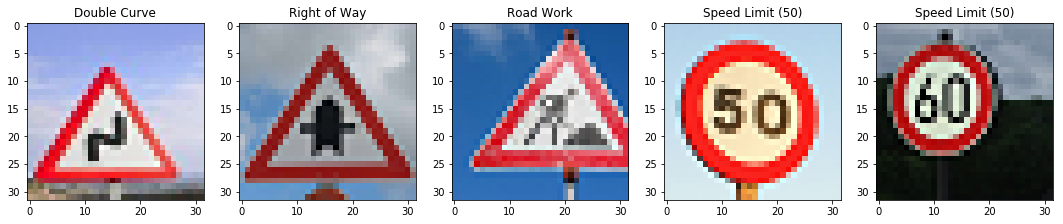

In [12]:
im1 = plt.imread('web_signs/double_curve_in.png')
im2 = plt.imread('web_signs/right_of_way_in.png')
im3 = plt.imread('web_signs/road_work_in.png')
im4 = plt.imread('web_signs/speed_limit50_in.png')
im5 = plt.imread('web_signs/speed_limit60_in.png')

to_array = lambda x : np.array(x)[:,:,0:3] # convert to array and strip alpha channel
images = np.array(list(map(to_array, [im1, im2, im3, im4, im5]))) # stick them in a single array

f, axarr = plt.subplots(1,5)
plt.subplots_adjust(right=2.5)
axarr[0].set_title('Double Curve')
axarr[0].imshow(im1)
axarr[1].set_title('Right of Way')
axarr[1].imshow(im2)
axarr[2].set_title('Road Work')
axarr[2].imshow(im3)
axarr[3].set_title('Speed Limit (50)')
axarr[3].imshow(im4)
axarr[4].set_title('Speed Limit (50)')
axarr[4].imshow(im5)

### Predict the Sign Type for Each Image

In [13]:
img_ph = tf.placeholder(shape=(5,32,32,3), dtype = tf.float32)
logits = inference(img_ph)
probs = tf.nn.softmax(logits)

### Analyze Performance

In [14]:
lbl_ph = tf.placeholder(shape=(5,), dtype=tf.int32)
loss, acc = get_loss(logits, lbl_ph)

labels = np.array([21, 11, 25, 2, 3])

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [15]:
top5 = tf.nn.top_k(probs, k=5)

with tf.Session() as sess:
    
    model = 'models/2018-04-09 01:40:58.923150.ckpt'

    saver.restore(sess, model)
    sess.run(
        tf.local_variables_initializer())
    estimates, accuracy = sess.run([top5, acc], feed_dict = {img_ph : images, lbl_ph : labels})

print("Accuracy: ", accuracy)

INFO:tensorflow:Restoring parameters from models/2018-04-09 01:40:58.923150.ckpt
Accuracy:  0.6


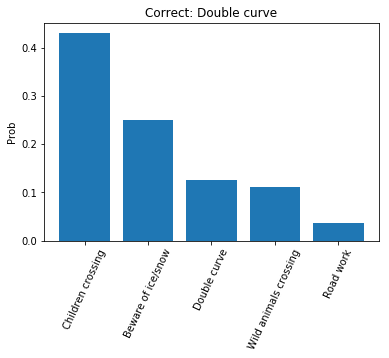

Children crossing: 0.43023384
Beware of ice/snow: 0.24991615
Double curve: 0.12594672
Wild animals crossing: 0.112306856
Road work: 0.037420932

Correct: Double curve


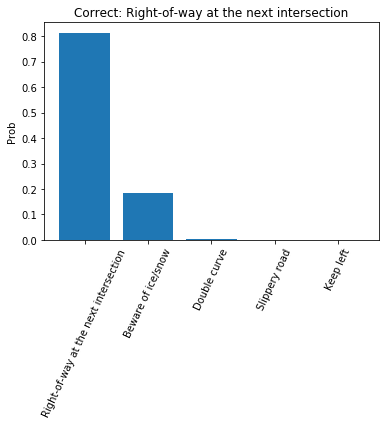

Right-of-way at the next intersection: 0.81353307
Beware of ice/snow: 0.18316866
Double curve: 0.0031985727
Slippery road: 3.5282243e-05
Keep left: 3.436647e-05

Correct: Right-of-way at the next intersection


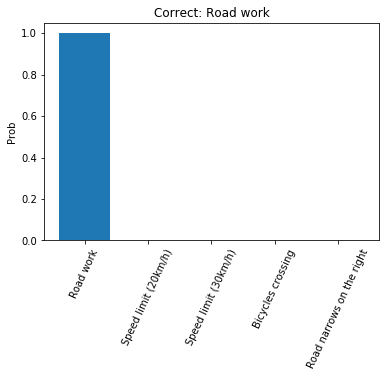

Road work: 0.9995653
Speed limit (20km/h): 0.00031607226
Speed limit (30km/h): 4.7975675e-05
Bicycles crossing: 2.7689399e-05
Road narrows on the right: 1.9351159e-05

Correct: Road work


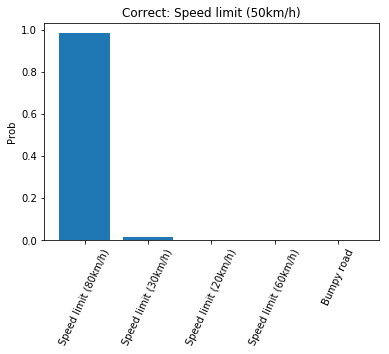

Speed limit (80km/h): 0.9823073
Speed limit (30km/h): 0.015654292
Speed limit (20km/h): 0.0016722515
Speed limit (60km/h): 0.0002174405
Bumpy road: 5.175265e-05

Correct: Speed limit (50km/h)


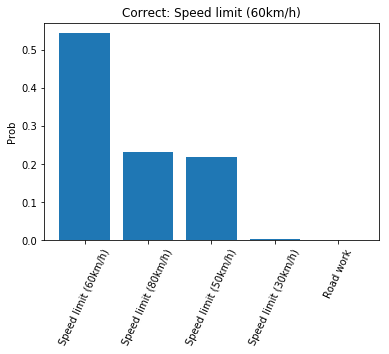

Speed limit (60km/h): 0.5442095
Speed limit (80km/h): 0.23121238
Speed limit (50km/h): 0.22023506
Speed limit (30km/h): 0.0030561201
Road work: 0.0003800827

Correct: Speed limit (60km/h)


In [20]:
for i in range (5):
    plt.bar(np.arange(5), estimates.values[i], align='center')
    plt.xticks(np.arange(5), list(map(lambda x: signname[x], estimates.indices[i])), rotation=65)
    plt.ylabel('Prob')
    plt.title('Correct: ' + signname[labels[i]])
    plt.show()
    for j in range(5):
        print(signname[estimates.indices[i][j]] + ": " + str(estimates.values[i][j]))
    print("\nCorrect: " + signname[labels[i]])